## Import des librairies

In [1]:
import numpy as np
import pandas as pd
from pprint import pprint

#Scraping des Tweets
import twint 
import nest_asyncio

#Preprocessing
from unidecode import unidecode
import re,string
from collections import Counter
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
import spacy
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import FrenchStemmer


#Dataviz
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import seaborn as sns
from wordcloud import WordCloud
from mpl_toolkits.mplot3d import Axes3D
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from yellowbrick.cluster import InterclusterDistance

#Vectorisation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Modèles de classification SKLearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF

#Modèles de classification Gensim
import gensim,  logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.nmf import Nmf
from operator import itemgetter
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel

#Logs d'erreurs
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

#Plots de progression
from tqdm import tqdm 

C:\ProgramData\Anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
C:\Users\eloue\AppData\Roaming\Python\Python38\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
nest_asyncio.apply()

# 1.<span style="color:red"> EXTRACTION & COLLECTE DES TWEETS </span>

In [3]:
# Configuration 
#c = twint.Config()
#c.Search ="europeansuperleague OR superleague européene"  #Topic de recherche
#c.Lang = "fr" #langue des Tweets
#c.Store_csv = True #Type de storage
#c.Output = "data/ESL.CSV" #Adresse du storage
#c.Pandas= True #conversion vers df
#c.Since = "2021-04-18" #date de début
#twint.run.Search(c) 

In [4]:
df = pd.read_csv("data/super_league_europeenne16.csv")
df = df.loc[df['language'] == "fr"]
df = df.loc[:, ['date', 'time','tweet', 'likes_count','retweets_count']]
df = df.drop_duplicates(subset='tweet', keep="first") #Suppression des doublons

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2400 entries, 0 to 2444
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            2400 non-null   object
 1   time            2400 non-null   object
 2   tweet           2400 non-null   object
 3   likes_count     2400 non-null   int64 
 4   retweets_count  2400 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 112.5+ KB


In [6]:
df['date'].describe().to_frame()

date
count         2400
unique          53
top     2021-04-19
freq          1029

In [7]:
df.isna().sum()

date              0
time              0
tweet             0
likes_count       0
retweets_count    0
dtype: int64

In [8]:
df.sample(10)

date      time                                              tweet  \
1670  2021-04-19  01:29:10  @high1ONEP @MediaParisien 🚨🎙Florentino Perez ⤵...   
515   2021-04-20  20:16:50  Les 12 clubs «fondateurs» de la Super League e...   
1169  2021-04-19  13:16:00  La banque JPMorgan annonce financer le projet ...   
2066  2021-04-18  18:34:35  🇪🇺L'UEFA a déclaré que les clubs participant à...   
2107  2021-04-18  17:44:20  Tous ces clubs qui sont favorables à la créati...   
783   2021-04-19  23:43:47  @AntooIMP Et que l’om n’arrive pas a se qualif...   
38    2021-05-27  10:53:59  Bernard Caïazzo : "Il faut tuer l'idéologie et...   
2429  2021-04-18  14:48:57  🚨 L'Atlético de Madrid fait bien parti du proj...   
1934  2021-04-18  22:10:59  Comment interprétez-vous le refus du Paris-Sai...   
1358  2021-04-19  10:24:06  La banque JPMorgan confirme qu'elle financera ...   

      likes_count  retweets_count  
1670            0               0  
515             2               0  
1169            0               0  
2066            1               0  
2107            0               0  
783             0               0  
38              2               1  
2429            7               0  
1934          496              20  
1358            0               1

# 2. <span style="color:blue"> EDA & PREPROCESSING</span>

### 2.1 <span style="color:black">  ANALYSE DESCRIPTIVE</span>

In [9]:
pd.options.display.max_colwidth = 80

In [10]:
#Conversion de la colonne tweet en liste
twt_list=df['tweet'].tolist()
print(f"La liste est composée de {len(twt_list)} tweets")

La liste est composée de 2400 tweets


In [11]:
i = 2390

for twt in twt_list:
    if i <= len(twt_list):
        print(f"Le tweet {i} est de longueur : {len(twt)}")
    i+=1

Le tweet 2390 est de longueur : 303
Le tweet 2391 est de longueur : 308
Le tweet 2392 est de longueur : 216
Le tweet 2393 est de longueur : 282
Le tweet 2394 est de longueur : 233
Le tweet 2395 est de longueur : 293
Le tweet 2396 est de longueur : 258
Le tweet 2397 est de longueur : 284
Le tweet 2398 est de longueur : 287
Le tweet 2399 est de longueur : 262
Le tweet 2400 est de longueur : 257


In [12]:
i = 2398

for twt in twt_list:
    liste_mots = twt.split() # Permet de séparer les mots d'une chaines de caractère en fonction d'un séparateur 
                             # par défault l'espace.
    if i <= len(twt_list):    
        print(f"Le tweet {i} contient {len(liste_mots)} mots")
        print(f"La liste de mots du tweet {i} : {liste_mots} \n")
        i+=1

Le tweet 2398 contient 43 mots
La liste de mots du tweet 2398 : ['⚽️🇪🇺', '«', "J'espère", 'que', 'cet', '#Euro2020', 'joué', 'dans', '11', 'pays', 'différents', 'à', "l'orée", 'de', 'la', 'présidence', '🇫🇷', 'de', "l'UE", 'par', '@EmmanuelMacron', 'créera', 'une', 'dynamique', 'pour', 'une', 'politique', 'sportive', 'européenne', '!', 'La', '#SuperLeague', 'est', 'un', 'avertissement,', 'réagissons', 'pour', 'protéger', 'nos', 'championnats', 'domestiques.', '»', 'https://t.co/6pEKlZA6f7'] 

Le tweet 2399 contient 51 mots
La liste de mots du tweet 2399 : ['@TalkMyFootball', '@Az21552916', 'Non', 'mais', 'le', 'problème', 'est', 'de', 'diviser', 'le', 'championnat', 'en', 'lots.', 'Dans', "l'affaire", 'de', 'la', 'super', 'league', 'européenne,', 'le', 'président', 'du', 'Real', 'parlait', 'du', 'désintérêt', 'grandissant', 'des', 'jeunes', 'pour', 'le', 'foot..', 'Bah', 'ouais,', 'quand', 'tu', 'es', 'jeune,', 'tu', 'as', 'beaucoup', 'de', 'priorité', 'que', 'les', '40', 'abonnements',

In [13]:
#Les 10 tweets ayant sucités le plus de réactions
df.sort_values(['likes_count','retweets_count'],ascending = (False, False)).head(10)

date      time  \
1162  2021-04-19  13:22:13   
2246  2021-04-18  16:27:56   
1986  2021-04-18  20:09:19   
2163  2021-04-18  17:05:35   
1180  2021-04-19  13:05:25   
990   2021-04-19  17:23:13   
933   2021-04-19  18:28:46   
2410  2021-04-18  15:02:27   
1240  2021-04-19  11:57:03   
1006  2021-04-19  17:00:15   

                                                                                tweet  \
1162  Des banderoles ont été affichées par les supporters des Reds devant Anfield....   
2246  L’UEFA remercie les clubs français et les clubs allemands qui ont refusé de ...   
1986  🔴 Sir Alex Ferguson dénonce le projet fermé d'une Superleague européenne : "...   
2163  Emmanuel Macron "salue la position des clubs français de refuser de particip...   
1180  Toni Kroos, en novembre dernier :  « Une SuperLeague européenne ? Nous ne so...   
990   Le gouvernement espagnol ne soutient pas la création d'une Super League euro...   
933   🔴 Le comité exécutif de l’UEFA discutera ce vendredi d’une possible exclusio...   
2410  🔴 Des clubs anglais, espagnols et italiens devraient officialiser dans les p...   
1240  Arsène Wenger : "La Super League, c'est une mauvaise idée. Le foot doit rest...   
1006  🔴 L’UEFA songerait à expulser dès maintenant les équipes impliquées dans la ...   

      likes_count  retweets_count  
1162         8778            1868  
2246         8261            1050  
1986         8051            1313  
2163         7146             720  
1180         4993            1114  
990          4375             467  
933          2896             468  
2410         2757             374  
1240         2748             606  
1006         2483             553

### 2.2 <span style="color:black">  NETTOYAGE & TRANSFORMATION DE LA LISTE DES TWEETS</span>

#### <p style="text-align: left;">La liste des stopwords utilisée est celle de Spacy + Lettres</p>

In [14]:
stopWords = ['a', 'abord', 'absolument', 'afin', 'ah', 'ai', 'aie', 'ailleurs', 'ainsi', 'ait', 'allaient', 'allo', 'allons', 
             'allô', 'alors', 'anterieur', 'anterieure', 'anterieures', 'apres', 'après', 'as', 'assez', 'attendu', 'au', 
             'aucun', 'aucune', 'aujourd', "aujourd'hui", 'aupres', 'auquel', 'aura', 'auraient', 'aurait', 'auront', 'aussi', 
             'autre', 'autrefois', 'autrement', 'autres', 'autrui', 'aux', 'auxquelles', 'auxquels', 'avaient', 'avais', 'avait', 
             'avant', 'avec', 'avoir', 'avons', 'ayant', 'bah', 'bas', 'basee', 'bat', 'beau', 'beaucoup', 'bien', 'bigre', 'boum', 
             'bravo', 'brrr',"ça", "c'", 'car', 'ce', 'ceci', 'cela', 'celle', 'celle-ci', 'celle-là', 'celles', 'celles-ci', 'celles-là', 
             'celui', 'celui-ci', 'celui-là', 'cent', 'cependant', 'certain', 'certaine', 'certaines', 'certains', 'certes', 'ces', 
             'cet', 'cette', 'ceux', 'ceux-ci', 'ceux-là', 'chacun', 'chacune', 'chaque', 'cher', 'chers', 'chez', 'chiche', 'chut', 
             'chère', 'chères', 'ci', 'cinq', 'cinquantaine', 'cinquante', 'cinquantième', 'cinquième', 'clac', 'clic', 'combien', 
             'comme', 'comment', 'comparable', 'comparables', 'compris', 'concernant', 'contre', 'couic', 'crac', 'c’', "d'", 'da', 
             'dans', 'de', 'debout', 'dedans', 'dehors', 'deja', 'delà', 'depuis', 'dernier', 'derniere', 'derriere', 'derrière', 
             'des', 'desormais', 'desquelles', 'desquels', 'dessous', 'dessus', 'deux', 'deuxième', 'deuxièmement', 'devant', 'devers', 
             'devra', 'different', 'differentes', 'differents', 'différent', 'différente', 'différentes', 'différents', 'dire', 
             'directe', 'directement', 'dit', 'dite', 'dits', 'divers', 'diverse', 'diverses', 'dix', 'dix-huit', 'dix-neuf', 
             'dix-sept', 'dixième', 'doit', 'doivent', 'donc', 'dont', 'douze', 'douzième', 'dring', 'du', 'duquel', 'durant', 'dès', 
             'désormais', 'd’', 'effet', 'egale', 'egalement', 'egales', 'eh', 'elle', 'elle-même', 'elles', 'elles-mêmes', 'en', 
             'encore', 'enfin', 'entre', 'envers', 'environ', 'es', 'est', 'et', 'etaient', 'etais', 'etait', 'etant', 'etc', 'etre', 
             'eu', 'euh', 'eux', 'eux-mêmes', 'exactement', 'excepté', 'extenso', 'exterieur', 'fais', 'faisaient', 'faisant', 'fait', 
             'façon', 'feront', 'fi', 'flac', 'floc', 'font', 'gens', 'ha', 'hein', 'hem', 'hep', 'hi', 'ho', 'holà', 'hop', 'hormis', 
             'hors', 'hou', 'houp', 'hue', 'hui', 'huit', 'huitième', 'hum', 'hurrah', 'hé', 'hélas', 'i', 'il', 'ils', 'importe', 
             "j'", 'je', 'jusqu', 'jusque', 'juste', 'j’', "l'", 'la', 'laisser', 'laquelle', 'las', 'le', 'lequel', 'les', 
             'lesquelles', 'lesquels', 'leur', 'leurs', 'longtemps', 'lors', 'lorsque', 'lui', 'lui-meme', 'lui-même', 'là', 'lès', 'l’', 
             "m'", 'ma', 'maint', 'maintenant', 'mais', 'malgre', 'malgré', 'maximale', 'me', 'meme', 'memes', 'merci', 'mes', 'mien', 'mienne', 
             'miennes', 'miens', 'mille', 'mince', 'minimale', 'moi', 'moi-meme', 'moi-même', 'moindres', 'moins', 'mon', 
             'moyennant', 'même', 'mêmes', 'm’', "n'", 'na', 'naturel', 'naturelle', 'naturelles', 'ne', 'neanmoins', 'necessaire', 
             'necessairement', 'neuf', 'neuvième', 'ni', 'nombreuses', 'nombreux', 'non', 'nos', 'notamment', 'notre', 'nous', 'nous-mêmes', 
             'nouveau', 'nul', 'néanmoins', 'nôtre', 'nôtres', 'n’', 'o', 'oh', 'ohé', 'ollé', 'olé', 'on', 'ont', 'onze', 'onzième', 'ore', 
             'ou', 'ouf', 'ouias', 'oust', 'ouste', 'outre', 'ouvert', 'ouverte', 'ouverts', 'où', 'paf', 'pan', 'par', 'parce', 'parfois', 
             'parle', 'parlent', 'parler', 'parmi', 'parseme', 'partant', 'particulier', 'particulière', 'particulièrement', 'pas', 'passé', 
             'pendant', 'pense', 'permet', 'personne', 'peu', 'peut', 'peuvent', 'peux', 'pff', 'pfft', 'pfut', 'pif', 'pire', 'plein', 'plouf', 
             'plus', 'plusieurs', 'plutôt', 'possessif', 'possessifs', 'possible', 'possibles', 'pouah', 'pour', 'pourquoi', 'pourrais', 'pourrait', 
             'pouvait', 'prealable', 'precisement', 'premier', 'première', 'premièrement', 'pres', 'probable', 'probante', 'procedant', 'proche', 
             'près', 'psitt', 'pu', 'puis', 'puisque', 'pur', 'pure', "qu'", 'quand', 'quant', 'quant-à-soi', 'quanta', 'quarante', 'quatorze', 
             'quatre', 'quatre-vingt', 'quatrième', 'quatrièmement', 'que', 'quel', 'quelconque', 'quelle', 'quelles', "quelqu'un", 'quelque', 
             'quelques', 'quels', 'qui', 'quiconque', 'quinze', 'quoi', 'quoique', 'qu’', 'rare', 'rarement', 'rares', 'relative', 'relativement', 
             'remarquable', 'rend', 'rendre', 'restant', 'reste', 'restent', 'restrictif', 'retour', 'revoici', 'revoilà', 'rien', "s'", 'sa', 
             'sacrebleu', 'sait', 'sans', 'sapristi', 'sauf', 'se', 'sein', 'seize', 'selon', 'semblable', 'semblaient', 'semble', 'semblent', 
             'sent', 'sept', 'septième', 'sera', 'seraient', 'serait', 'seront', 'ses', 'seul', 'seule', 'seulement', 'si', 'sien', 'sienne', 
             'siennes', 'siens', 'sinon', 'six', 'sixième', 'soi', 'soi-même', 'soit', 'soixante', 'son', 'sont', 'sous', 'souvent', 'specifique', 
             'specifiques', 'speculatif', 'stop', 'strictement', 'subtiles', 'suffisant', 'suffisante', 'suffit', 'suis', 'suit', 'suivant', 
             'suivante', 'suivantes', 'suivants', 'suivre', 'superpose', 'sur', 'surtout', 's’', "t'", 'ta', 'tac', 'tant', 'tardive', 'te', 
             'tel', 'telle', 'tellement', 'telles', 'tels', 'tenant', 'tend', 'tenir', 'tente', 'tes', 'tic', 'tien', 'tienne', 'tiennes', 
             'tiens', 'toc', 'toi', 'toi-même', 'ton', 'touchant', 'toujours', 'tous', 'tout', 'toute', 'toutefois', 'toutes', 'treize', 'trente', 
             'tres', 'trois', 'troisième', 'troisièmement', 'trop', 'très', 'tsoin', 'tsouin', 'tu', 'té', 't’', 'un', 'une', 'unes', 
             'uniformement', 'unique', 'uniques', 'uns', 'va', 'vais', 'vas', 'vers', 'via', 'vif', 'vifs', 'vingt', 'vivat', 'vive', 'vives', 
             'vlan', 'voici', 'voilà', 'vont', 'vos', 'votre', 'vous', 'vous-mêmes', 'vu', 'vé', 'vôtre', 'vôtres', 'zut', 'à', 'â', 'ça', 'ès', 
             'étaient', 'étais', 'était', 'étant', 'été', 'être', 'ô', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 
             'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'qu','etes','à','quelqu']

stopWords = [unidecode(sw) for sw in stopWords]

#### <p style="text-align: left;">Définitions de fonctions de pré-processing</p>

In [15]:
#Fonction qui supprime les emojis avec un dict des emoticones 
emoji_pattern = re.compile("["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        u"\U0001F1F2-\U0001F1F4"  # Macau flag
                        u"\U0001F1E6-\U0001F1FF"  # flags
                        u"\U0001F600-\U0001F64F"
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        u"\U0001f926-\U0001f937"
                        u"\U0001F1F2"
                        u"\U0001F1F4"
                        u"\U0001F620"
                        u"\u200d"
                        u"\u2640-\u2642"
                       "]+", flags=re.UNICODE)  

def emoji(string):
    return emoji_pattern.sub(r'', string)

In [16]:
# Création du stemmer
stemmer = FrenchStemmer()

In [17]:
def stemmatise_text(text, stemmer):

    return " ".join([stemmer.stem(word) for word in text.split()])


In [18]:
def df_cleaner(pandasSeries, stopWords):
    
    print("#### Nettoyage en cours ####") 
    
    # confirmation que chaque article est bien de type str
    pandasSeries = pandasSeries.apply(lambda x : str(x))
    
    # Passage en minuscule
    print("... Passage en minuscule") 
    pandasSeries = pandasSeries.apply(lambda x : x.lower())
    
    #Suppression de la ponctuation
    print("... Suppression de la ponctuation")
    pandasSeries = pandasSeries.apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))
    
    #Suppression des unicodes
    print("... Suppression des unicodes")
    pandasSeries = pandasSeries.apply(lambda x: re.sub('[«»]', '', x))
    
                                       
    # Suppression des urls
    print("... Suppression des urls") 
    pandasSeries = pandasSeries.apply(lambda x :re.sub(r"http\S+", '', x))
    
    # Suppression des emojis
    print("... Suppression des emojis") 
    pandasSeries = pandasSeries.apply(emoji)
    
    # Suppression des stop words
    print("... Suppression des stop words") 
    pandasSeries = pandasSeries.apply(lambda x:' '.join([word for word in x.split() if word not in stopWords]))
    pandasSeries = pandasSeries.apply(lambda x: re.sub('[àç]', '', x))
    
    # Stemmatisation
    #print("... Stemmatisation") 
    #pandasSeries = pandasSeries.apply(lambda x : stemmatise_text(x, stemmer))
    
    print("#### Nettoyage OK! ####")

    return pandasSeries

#### <p style="text-align: left;">Application des fonctions de pre-processing sur la colonne `tweet` et stockage du résultat dans la colonne `tweet_clean`</p>

In [19]:
%%time 
df['tweet_clean'] = df_cleaner(df['tweet'], stopWords)

df[['tweet', 'tweet_clean']].sample(10)

#### Nettoyage en cours ####
... Passage en minuscule
... Suppression de la ponctuation
... Suppression des unicodes
... Suppression des urls
... Suppression des emojis
... Suppression des stop words
#### Nettoyage OK! ####
Wall time: 518 ms


tweet  \
2386  ⚽️ #SuperLeague Européenne : les confirmations viennent des médias américain...   
683   @Piccoli459 Franchement imagine une superleague européenne où ensuite les me...   
2123  Fin de l’air Messi/CR7, le  foot de haut niveau est en énorme baisse depuis ...   
270   Le plan de la super league européenne au bord de l'effondrement  La perte de...   
1867                  Création de la Super League européenne... c’est la fin les amis   
1873  Si on se considère comme un grand club, c'est de la responsabilité des (futu...   
2328  Imaginez après l’annonce de ce soir pour la SuperLeague Européenne l’UEFA de...   
878   @JeremyFilosa @clubdefootmtl Salut Jérémy, comment expliques-tu le silence r...   
277   Les dirigeants de clubs qui ont déclenché une guerre civile dans le football...   
323   Ne me parlez plus jamais de la "SuperLeague européenne". Cette compétition d...   

                                                                          tweet_clean  
2386  superleague européenne confirmations viennent médias américains après nytime...  
683   piccoli459 franchement imagine superleague européenne où ensuite meilleurs i...  
2123  fin l’air messicr7 foot haut niveau énorme baisse années superleague europée...  
270   plan super league européenne bord leffondrement perte équipes grandes riches...  
1867                                  création super league européenne c’est fin amis  
1873  considère grand club cest responsabilité futurs dirigeants daccrocher wagon ...  
2328  imaginez après l’annonce soir superleague européenne l’uefa decide bannir cl...  
878   jeremyfilosa clubdefootmtl salut jérémy expliquestu silence radio stations s...  
277   dirigeants clubs déclenché guerre civile football anglais rejoignant super l...  
323              parlez jamais superleague européenne compétition merde jamais existé

# 3. <span style="color:GREEN">  DATA VIZ </span>

### 3.1 <span style="color:black">  Nombre de mots </span>

In [20]:
df1 = (df['tweet_clean'].str.split(expand=True).stack().value_counts().rename_axis('mots').reset_index(name='Occurrences')).set_index('mots')
df1.head(21)

Occurrences
mots                    
européenne          2360
league              1645
super               1612
superleague         1074
clubs                733
football             447
projet               340
compétition          261
ligue                242
cest                 221
a                    219
luefa                203
c’est                176
création             176
foot                 175
12                   169
club                 165
monde                161
florentino           146
madrid               143
joueurs              138

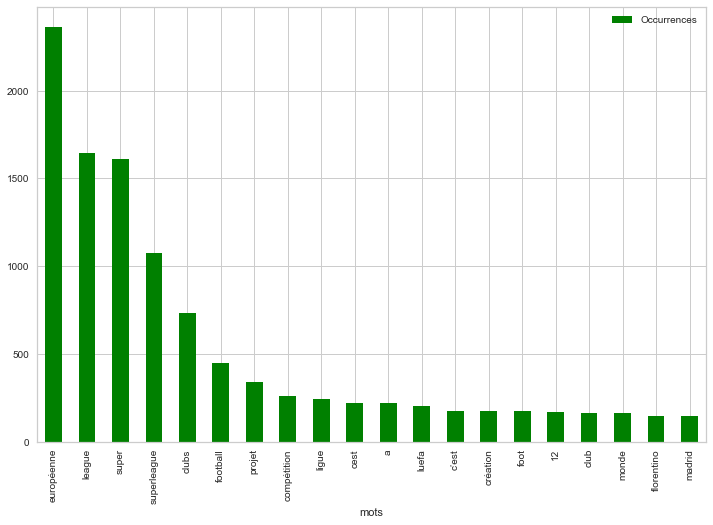

In [21]:
df1.head(20).plot(kind = "bar", figsize=(12, 8), color = "Green");

### 3.2 <span style="color:black"> Bigrams & Trigrams</span>

In [22]:
corpus = df['tweet_clean'].str.split()

In [23]:
# bigrammes dans un document
print(f"Notre document n° 99: {corpus[99]} \n")


print(f"La liste des bigrammes présents dans le document n°99 : {list(nltk.bigrams(corpus[99]))}")
print("")
print(f"La liste des Trigrammes présents dans le document n°99 : {list(nltk.trigrams(corpus[99]))}")

Notre document n° 99: ['officiel', '12', 'clubs', 'super', 'league', 'européenne', 'manutd', 'don', 'collectif', '15', 'millions', 'deuros', 'bonnes', 'causes', 'perdront', '5', 'recettes', 'compétitions', 'luefa', 'saison', 'prochaine', 'dinterdiction', 'compétition', 'mufc'] 

La liste des bigrammes présents dans le document n°99 : [('officiel', '12'), ('12', 'clubs'), ('clubs', 'super'), ('super', 'league'), ('league', 'européenne'), ('européenne', 'manutd'), ('manutd', 'don'), ('don', 'collectif'), ('collectif', '15'), ('15', 'millions'), ('millions', 'deuros'), ('deuros', 'bonnes'), ('bonnes', 'causes'), ('causes', 'perdront'), ('perdront', '5'), ('5', 'recettes'), ('recettes', 'compétitions'), ('compétitions', 'luefa'), ('luefa', 'saison'), ('saison', 'prochaine'), ('prochaine', 'dinterdiction'), ('dinterdiction', 'compétition'), ('compétition', 'mufc')]

La liste des Trigrammes présents dans le document n°99 : [('officiel', '12', 'clubs'), ('12', 'clubs', 'super'), ('clubs', 'su

### 3.3 <span style="color:black"> Nuages de mots </span>

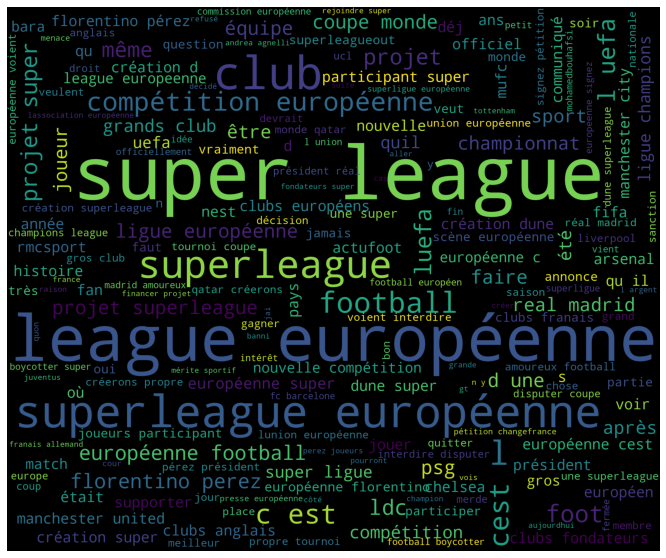

In [24]:
wordcloud = WordCloud(width = 1200,height = 1000,scale = 2, background_color='black',collocations=True).generate(' '.join(df["tweet_clean"]))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

# 4. <span style="color:Orange">  Classification non supervisée </span>

[![Unsupervised.png](https://i.postimg.cc/TYBv1nJ3/Unsupervised.png)](https://postimg.cc/svPN0QLk)

**Clustering**  : c'est une méthode de regroupement des objets en groupes de telle sorte que ceux qui présentent le plus de similitudes restent dans un groupe et présentent moins ou pas de similitudes avec les objets d'un autre groupe. L'analyse de cluster trouve les points communs entre les objets de données et les catégorise selon la présence et l'absence de ces points communs.

**Association**: Une règle d'association est une méthode d'apprentissage non supervisée qui est utilisée pour trouver les relations entre les variables dans une base de données. Il détermine l'ensemble des éléments qui se produisent ensemble dans l'ensemble de données. La règle d'association peut rendre une stratégie marketing plus efficace. Comme les personnes qui achètent un article X (supposons un pain) ont également tendance à acheter un article Y (beurre/confiture). Un exemple typique de règle d'association est l'analyse du panier de marché.

[![Scikit-learn-logo-small.png](https://i.postimg.cc/xTGTfcqV/Scikit-learn-logo-small.png)](https://postimg.cc/ykdzn6FL)

### 4.1 <span style="color:black">  K-means Clustering</span>

####  4.1.1 <span style="color:black">  TF-IDF</span>

Le ratio TF-IDF (Term-Frequency - Inverse Document Frequency) permet de pondérer la fréquence des tokens (mots dans notre corpus) dans un document par son importance relative dans les autres documents.

Ce score tient donc compte de la composition de notre corpus.

In [25]:
#Vectorisation des bigram et avec un minimum d'apparitions de 2 fois
vectorizer = TfidfVectorizer(ngram_range=range(1,3), min_df=2,stop_words=stopWords)
X = vectorizer.fit_transform(df['tweet_clean'])

print(X.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [26]:
pd.DataFrame(vectorizer.get_feature_names()).sample(10)

0
413            artistique
4626  retrouvent fâcheuse
2121      favorable super
1355             dintérêt
5630              équipés
313         annoncé lundi
1262   davoir superleague
3848  origine superleague
2809   jouant superleague
5589            également

####  4.1.2 <span style="color:black">  Choix du nombre de clusters `true_k` avec la méthode "elbow"</span>

Le choix du true_k se fera graphiquement en prenant l'abcisse du coude correspondant à une faible pente du graph.

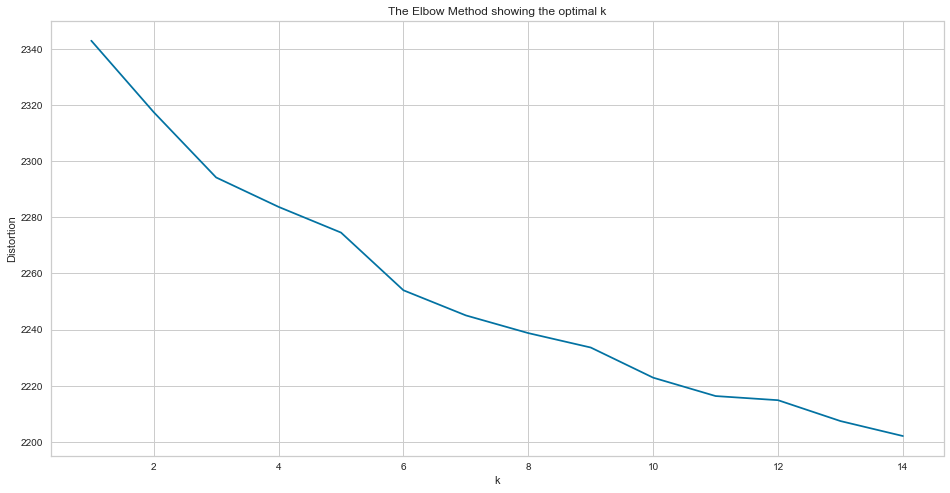

In [27]:
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.grid(True)
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

####  4.1.3 <span style="color:black">  Application de l'algorithme K-means</span>

In [28]:
true_k = 5
model = KMeans(n_clusters=true_k, init='k-means++')
model.fit(X)

print("Top termes par cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % (terms[ind])),
    print

print("\n")

Top termes par cluster:
Cluster 0:
 superleague européenne
 superleague
 européenne
 projet superleague
 clubs
 projet
 création
 football
 création superleague
 foot
Cluster 1:
 amoureux football
 boycotter super
 football boycotter
 madrid amoureux
 europeenne signez
 amoureux
 président réal
 signez
 signez pétition
 pérez président
Cluster 2:
 superleague
 clubs
 compétition
 européenne
 compétition européenne
 ligue
 super
 league
 super league
 cest
Cluster 3:
 manchester
 city
 united
 manchester city
 manchester united
 chelsea
 milan
 liverpool
 league européenne
 clubs
Cluster 4:
 league européenne
 league
 super league
 super
 européenne
 football
 clubs
 projet
 projet super
 monde




####  4.1.4 <span style="color:black">  Test de prédiction du cluster</span>

In [29]:
print("\n")
print("Prediction")
X = vectorizer.transform(["qui est la banque qui finance cette proposition"])
predicted = model.predict(X)
print(predicted)



Prediction
[2]


####  4.1.5 <span style="color:black">  Visualisation de la distance interclusters</span>

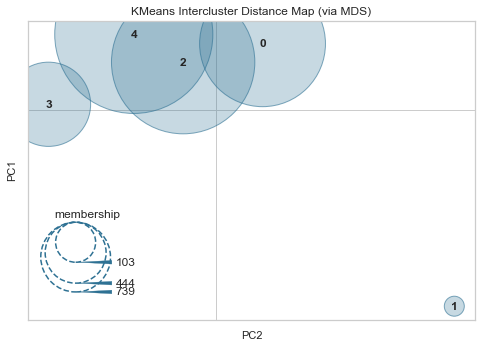

In [30]:
visualizer = InterclusterDistance(model)
visualizer.fit(X)
visualizer.show();

### 4.2 <span style="color:black">  Topic Modelling (LatentDirichletAllocation)</span>

####  4.2.1 <span style="color:black">  Vectorisation & Transformation </span>

In [31]:
#Filtre appliqué sur les mots qui apparaissent dans moins de 10% des tweets 
vectorizer = CountVectorizer(min_df=25, token_pattern=r'\w+|\$[\d\.]+|\S+n')

In [32]:
tf = vectorizer.fit_transform(df['tweet_clean']).toarray()

In [33]:
tf_feature_names = vectorizer.get_feature_names()

####  4.2.2 <span style="color:black">  Modélisation </span>

In [34]:
#Choix de nombre de topics arbitraire
number_of_topics = 6

model2 = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model2.fit(tf)

LatentDirichletAllocation(n_components=6, random_state=0)

In [35]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [36]:
no_top_words = 10
display_topics(model2, tf_feature_names, no_top_words)

Topic 0 words Topic 0 weights Topic 1 words Topic 1 weights Topic 2 words  \
0         monde           161.2        league           959.2             l   
1       joueurs           126.6         super           951.6             d   
2         coupe           121.2    européenne           727.6    européenne   
3         perez            59.9      football           183.5   superleague   
4    européenne            56.3     président            98.9          uefa   
5    florentino            53.6    florentino            87.8           ’un   
6   participant            50.2          foot            73.6             e   
7         super            49.0        projet            72.7          être   
8        league            47.9         perez            67.5         clubs   
9        propre            41.2        madrid            65.1             s   

  Topic 2 weights Topic 3 words Topic 3 weights Topic 4 words Topic 4 weights  \
0           394.3   superleague           532.7         clubs           572.7   
1           252.2    européenne           478.2    européenne           469.9   
2           243.9             a           185.6   superleague           297.3   
3           194.0           est           159.0        league           204.3   
4           191.9             c           152.0         super           190.3   
5           109.2      football           140.5         luefa           178.4   
6           101.2             l            95.5            12           169.1   
7            86.6          foot            90.7         ligue           153.1   
8            79.7          cest            78.4   compétition           145.3   
9            78.2        projet            69.1     champions            95.2   

  Topic 5 words Topic 5 weights  
0        league           399.2  
1    européenne           387.1  
2         super           383.3  
3        projet           132.0  
4    manchester            96.2  
5      football            90.4  
6          city            73.2  
7     liverpool            72.6  
8          club            70.8  
9       chelsea            65.2

Sans trop de surprises, les termes ayant le plus de poids (occurences) dans les tweets sont :
- super league européenne
- UEFA / FIFA
- 12 clubs fondateurs de l'ESL
- Florentino Perez le président du Réal Madrid par celui l'annonce est venue
- PSG / Real / Manchester U/ Manchester City/ Arsenal / Milan : qui sont les clubs protagonistes ou antagonistes du projet

### 4.3 <span style="color:black">  Topic Modelling (Non-Negative Matrix Factorization)</span>

####  4.3.1 <span style="color:black">  Vectorisation & Transformation </span>

In [37]:
D = TfidfVectorizer(min_df=25, stop_words=stopWords)
# Fit and transform
F = D.fit_transform(df.tweet_clean)

####  4.3.2 <span style="color:black">  Modélisation </span>

In [38]:
model3 = NMF(n_components=5, random_state=5, init='nndsvda')
model3.fit(F)
nmf_features = model3.transform(F)

In [39]:
components_df = pd.DataFrame(model3.components_, columns=D.get_feature_names())

####  4.3.3 <span style="color:black"> Top5 des Topics obtenus </span>

In [40]:
for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'les mots les plus récurrents du topic {topic} :')
    print(tmp.nlargest(5))
    print('\n')

les mots les plus récurrents du topic 0 :
league        3.188154
super         3.118565
européenne    2.032661
création      0.178814
foot          0.169846
Name: 0, dtype: float64


les mots les plus récurrents du topic 1 :
superleague    2.979302
européenne     1.491410
ligue          0.190904
compétition    0.187572
création       0.174235
Name: 1, dtype: float64


les mots les plus récurrents du topic 2 :
clubs          2.410728
12             0.817913
compétition    0.657415
uefa           0.540495
luefa          0.540132
Name: 2, dtype: float64


les mots les plus récurrents du topic 3 :
football      2.936123
président     0.249230
monde         0.219460
sport         0.199163
florentino    0.178757
Name: 3, dtype: float64


les mots les plus récurrents du topic 4 :
projet      2.584441
foot        0.727257
ligue       0.345292
banque      0.263618
jpmorgan    0.197743
Name: 4, dtype: float64




[![1-xbe-Uz-Ef-XA5tnd-W9z-M4g-Or-Q.png](https://i.postimg.cc/XqkSbBL2/1-xbe-Uz-Ef-XA5tnd-W9z-M4g-Or-Q.png)](https://postimg.cc/tnJmdTLP)

### 4.4 <span style="color:black">  Topic Modelling (LDA) </span>

- **Conversion en liste**

In [41]:
#Conversion en liste
tweet_list = df['tweet_clean'].to_list()

- **Création des bigram & Trigram**

In [42]:
bigram = gensim.models.Phrases(tweet_list, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tweet_list], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

- **Reprocessing : Lemmatisation / Tokenisation & Suppression des stop words**

In [43]:
def process_words(texts, stop_words=stopWords, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('fr_core_news_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

In [44]:
tweet_ready = process_words([tweet_list])  # Liste des tweets

In [45]:
tweet_dict = corpora.Dictionary(tweet_ready)

#tweet_dict.filter_extremes(no_below=2, no_above=.99) #Filtre pour les valeurs extrêmes

# Creation du corpus
corpus = [tweet_dict.doc2bow(text) for text in tweet_ready]

# Build LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=tweet_dict,
                                           num_topics=10, 
                                           random_state=100)


pprint(ldamodel.print_topics())

[(0,
  '0.069*"européen" + 0.051*"super" + 0.037*"leagu" + 0.028*"superleagu" + '
  '0.024*"club" + 0.014*"league" + 0.013*"football" + 0.010*"compétition" + '
  '0.010*"projet" + 0.005*"luefer"'),
 (1,
  '0.059*"européen" + 0.042*"super" + 0.025*"superleagu" + 0.024*"leagu" + '
  '0.019*"club" + 0.012*"football" + 0.011*"league" + 0.008*"projet" + '
  '0.007*"compétition" + 0.006*"luefer"'),
 (2,
  '0.036*"européen" + 0.025*"super" + 0.018*"club" + 0.016*"superleagu" + '
  '0.014*"leagu" + 0.009*"football" + 0.009*"league" + 0.006*"compétition" + '
  '0.006*"projet" + 0.004*"florentino"'),
 (3,
  '0.064*"européen" + 0.050*"super" + 0.037*"leagu" + 0.030*"superleagu" + '
  '0.030*"club" + 0.015*"football" + 0.014*"league" + 0.009*"projet" + '
  '0.008*"compétition" + 0.008*"luefer"'),
 (4,
  '0.061*"européen" + 0.027*"super" + 0.021*"superleagu" + 0.021*"leagu" + '
  '0.021*"club" + 0.012*"football" + 0.009*"league" + 0.009*"projet" + '
  '0.008*"compétition" + 0.005*"création"'),
 (5,

#### 4.4.1 Cohérance & Perplexité

- Cohérance : Les mesures de cohérence des topics évaluent un seul Topic en mesurant le degré de similitude sémantique entre les mots à score élevé dans ce même topic. Ces mesures permettent de distinguer les topics qui sont sémantiquement interprétables des autres topics qui sont des artefacts d'inférence statistique.

 - Perplexité: est une mesure statistique de la capacité d'un modèle de probabilité à prédire un échantillon.

In [46]:
base_perplexity = ldamodel.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=ldamodel, texts=tweet_ready, 
                                   dictionary=tweet_dict, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)


Perplexity:  -7.790874261128339

Coherence Score:  0.2525561989829439


#### 4.4.2 Tunning des hyperparamètres du modèle

- #### 4.4.2.1 Perplexité

 - Remarque : Une perplexité négative est principalement dûe au log_perplexity qui génère le log de la probabilité

 -  Plus la perplexité est elevée plus le modèle prédit mieux.

In [47]:
def plot_perplexity(dict_, corpus):
    num_topics_range = range(2, 20)
    perplexities = []
    for num_topics in num_topics_range:
        lda_model = ldamodel
        perplexities.append(lda_model.log_perplexity(corpus))
    plt.plot(num_topics_range, perplexities, color='blue', marker='o', markersize=5)
    plt.title('Log perplexité en fonction des nombres des topics')
    plt.xlabel('Nombre de topics')
    plt.ylabel('Log perplexité')
    plt.grid()
    plt.show()

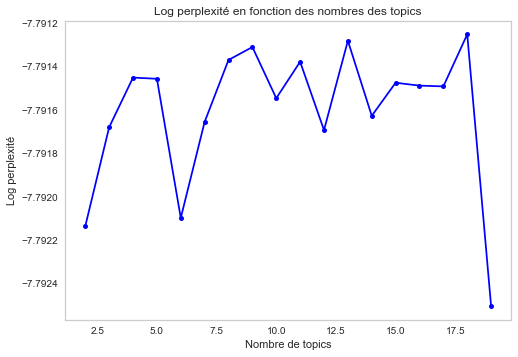

In [48]:
number_topics = 15
plot_perplexity(tweet_dict, corpus)

- #### 4.4.2.2 Cohérance

 - La cohérance varie généralement de 0.3 (bas) --> 0.6(bon) --> 0.9 ~ 1 (faux)
 - La cohérance peutêtre améliorée par le choix des topics, le changement des coefficients alpha ou beta

In [49]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    ldamodel = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=tweet_ready, dictionary=tweet_dict, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

- Résultat du tunning:

In [50]:
df_result=pd.read_csv('lda_tuning_results.csv')

In [51]:
df_result.sort_values(["Coherence"], axis=0, ascending=False, inplace=True) 
df_result.head(10)

Validation_Set  Topics       Alpha                Beta  Coherence
388    100% Corpus       5  asymmetric  0.9099999999999999   0.502472
533    100% Corpus      10   symmetric  0.9099999999999999   0.500089
513    100% Corpus      10        0.01  0.9099999999999999   0.488323
488    100% Corpus       9        0.31  0.9099999999999999   0.487897
298    100% Corpus       2  asymmetric  0.9099999999999999   0.486332
518    100% Corpus      10        0.31  0.9099999999999999   0.477772
487    100% Corpus       9        0.31                0.61   0.473631
417    100% Corpus       6  asymmetric                0.61   0.472196
477    100% Corpus       8  asymmetric                0.61   0.466220
58      75% Corpus       3  asymmetric  0.9099999999999999   0.463794

- #### 4.4.2.3 Modèle amélioré

In [52]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=tweet_dict,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='asymmetric',
                                           iterations=100,
                                           eta=0.9)


pprint(ldamodel.print_topics()) 

[(0,
  '0.069*"européen" + 0.044*"super" + 0.033*"leagu" + 0.027*"superleagu" + '
  '0.025*"club" + 0.012*"football" + 0.012*"league" + 0.010*"projet" + '
  '0.008*"compétition" + 0.006*"luefer"'),
 (1,
  '0.001*"européen" + 0.000*"super" + 0.000*"superleagu" + 0.000*"leagu" + '
  '0.000*"club" + 0.000*"football" + 0.000*"league" + 0.000*"projet" + '
  '0.000*"compétition" + 0.000*"luefer"'),
 (2,
  '0.000*"européen" + 0.000*"super" + 0.000*"club" + 0.000*"superleagu" + '
  '0.000*"leagu" + 0.000*"football" + 0.000*"league" + 0.000*"projet" + '
  '0.000*"compétition" + 0.000*"florentino"'),
 (3,
  '0.002*"européen" + 0.001*"super" + 0.001*"leagu" + 0.001*"superleagu" + '
  '0.001*"club" + 0.000*"football" + 0.000*"league" + 0.000*"projet" + '
  '0.000*"compétition" + 0.000*"luefer"'),
 (4,
  '0.001*"européen" + 0.000*"super" + 0.000*"superleagu" + 0.000*"club" + '
  '0.000*"leagu" + 0.000*"football" + 0.000*"projet" + 0.000*"league" + '
  '0.000*"compétition" + 0.000*"création"')]


In [53]:
base_perplexity = ldamodel.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=ldamodel, texts=tweet_ready, 
                                   dictionary=tweet_dict, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)


Perplexity:  -6.839826817789602

Coherence Score:  0.25033938258050104


- #### 4.4.2.4 Visualisation des topics obtenus

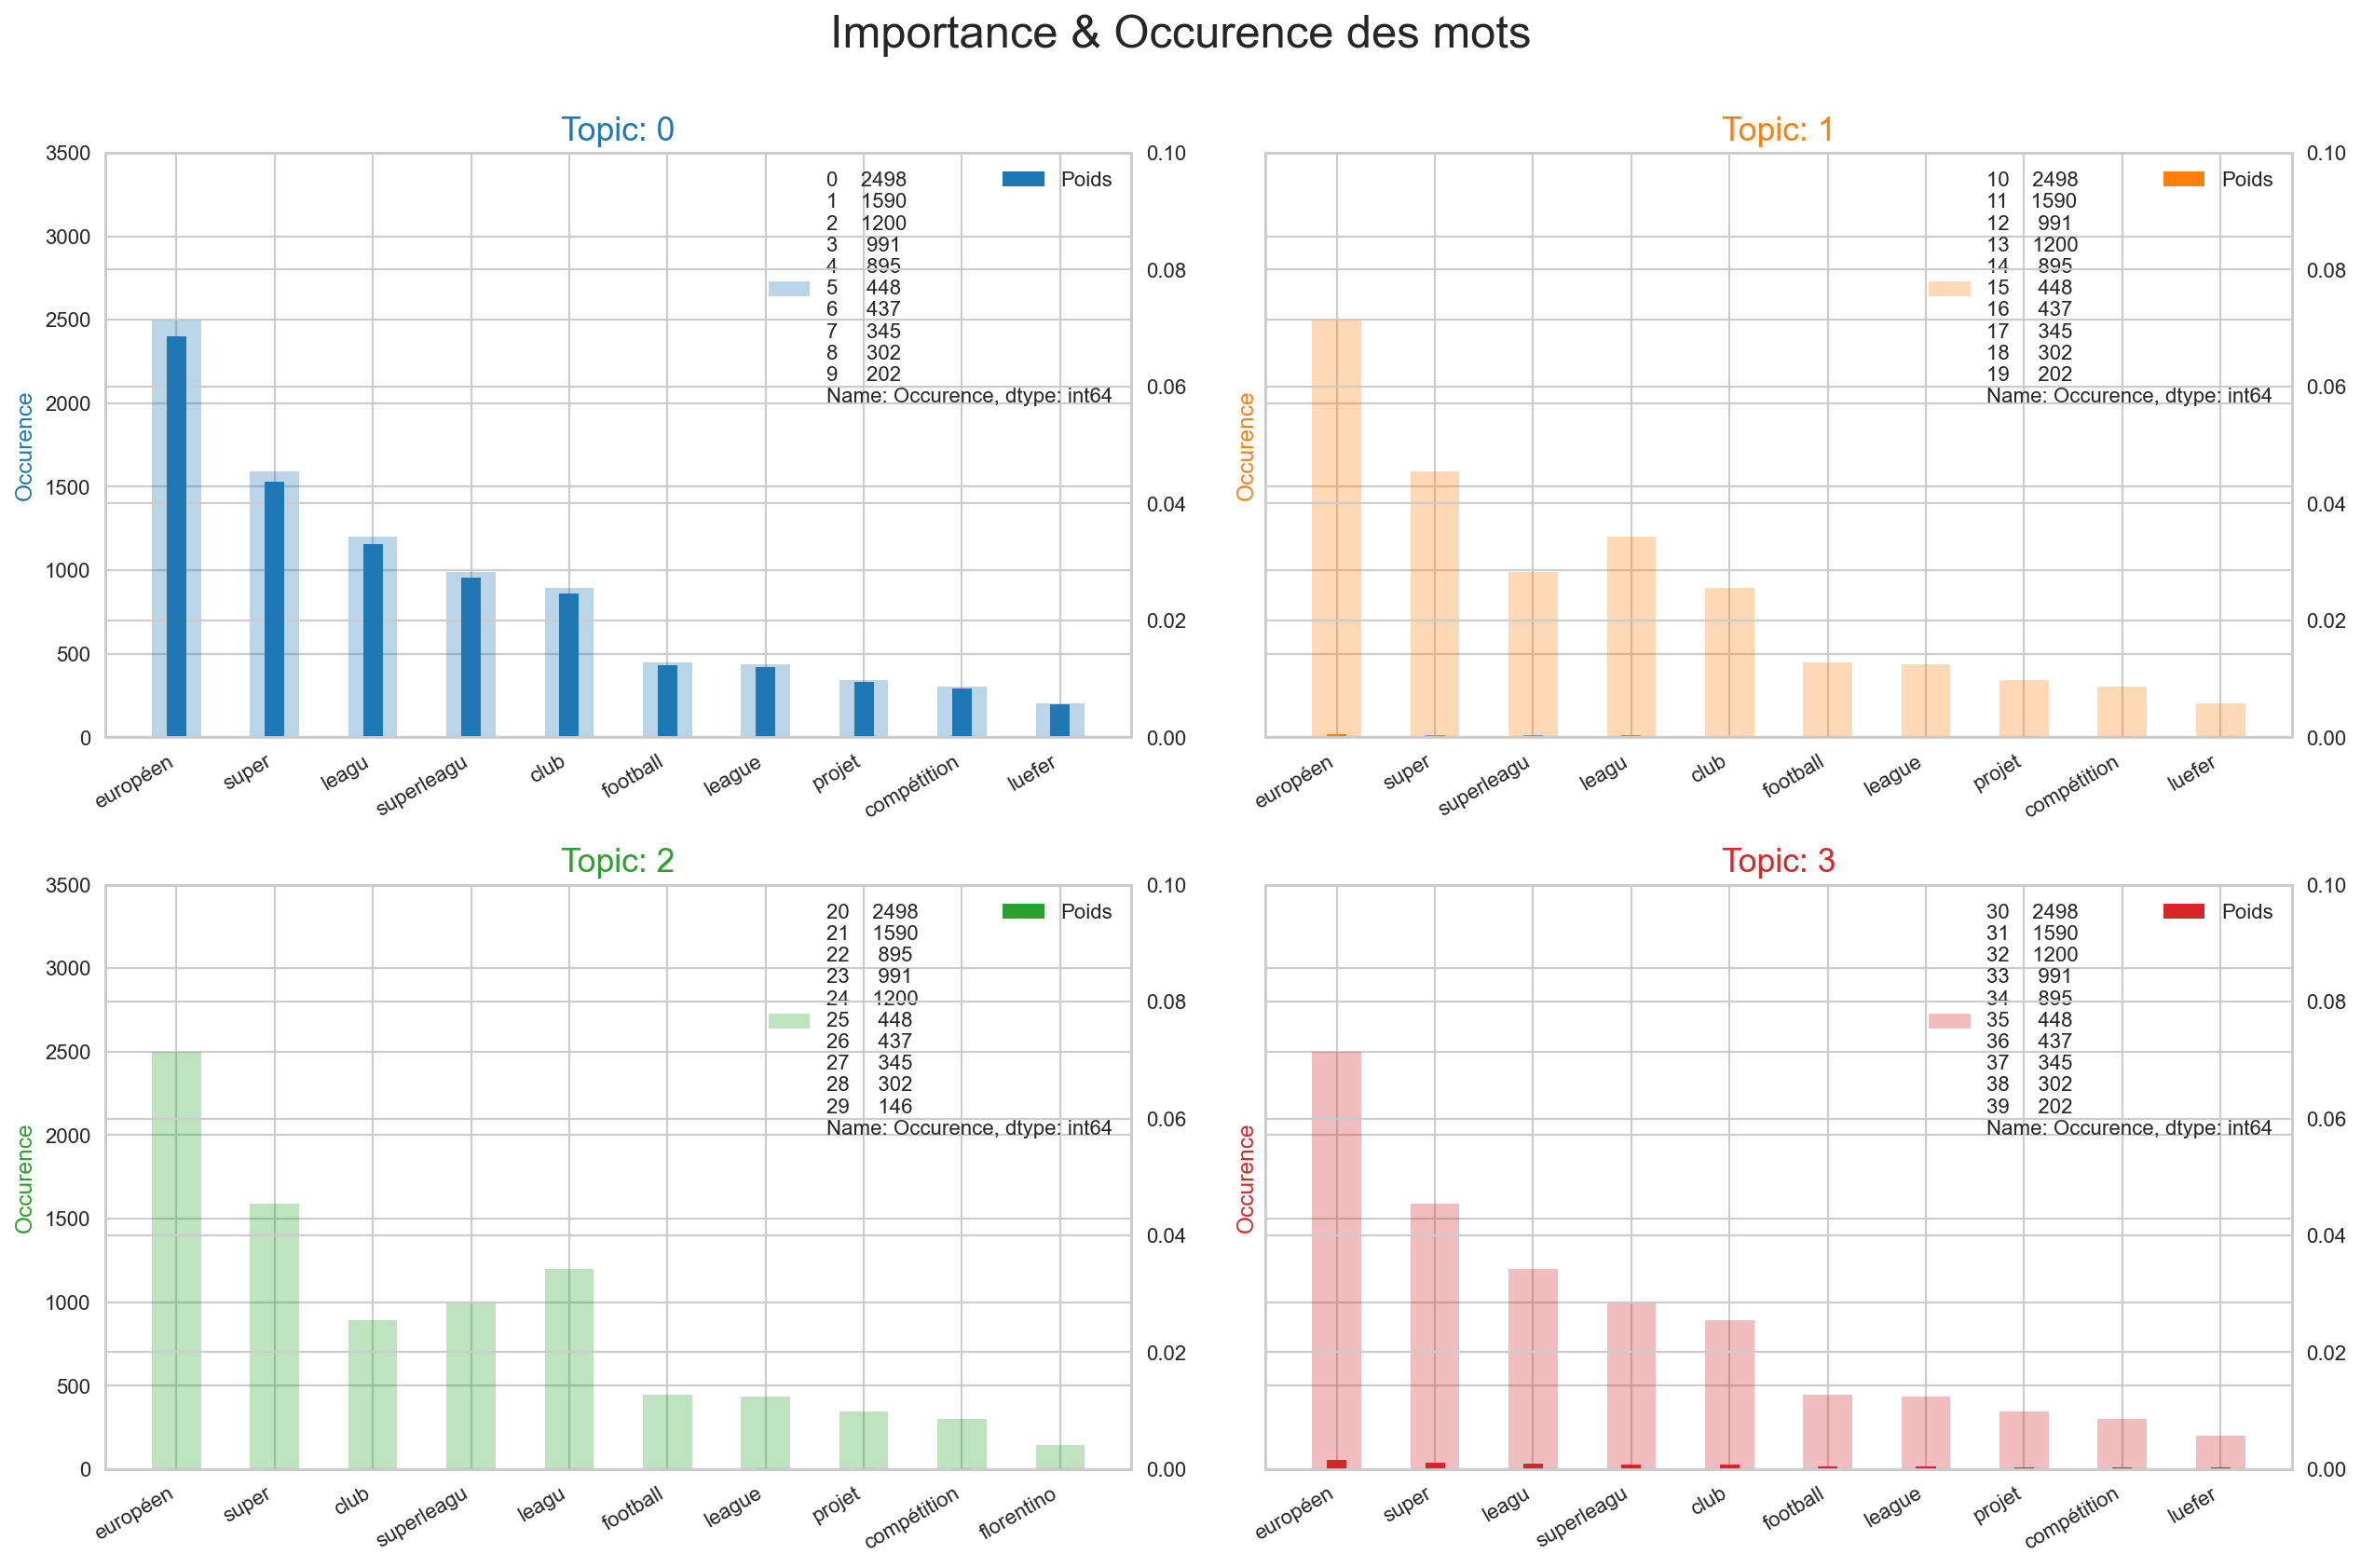

In [54]:
topics = ldamodel.show_topics(formatted=False)
data_flat = [w for w_list in tweet_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['Mot', 'topic_id', 'importance', 'Occurence'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='Mot', height="Occurence", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Occurence')
    ax_twin = ax.twinx()
    ax_twin.bar(x='Mot', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Poids')
    ax.set_ylabel('Occurence', color=cols[i])
    ax_twin.set_ylim(0, 0.100); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticks(df.loc[df.topic_id==i, 'Mot'])
    ax.set_xticklabels(df.loc[df.topic_id==i, 'Mot'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='best'); ax_twin.legend(loc='upper right')
fig.tight_layout(w_pad=2)    
fig.suptitle('Importance & Occurence des mots', fontsize=22, y=1.05)    
plt.show()

In [55]:
pyLDAvis.enable_notebook()
gensim_dictionary = tweet_dict
gensim_corpus = corpus
lda_model = ldamodel


lda_visualization = gensimvis.prepare(lda_model, gensim_corpus, gensim_dictionary, sort_topics=False)
pyLDAvis.display(lda_visualization)

### 4.5 <span style="color:black">  Topic Modelling (NMF) </span>

In [56]:
dictionary = Dictionary(tweet_ready)

corpus = [dictionary.doc2bow(text) for text in tweet_ready]

- **Création du bag of words avec un format : (list of(token_id, token_count))**

In [57]:
corpus = [dictionary.doc2bow(text) for text in tweet_ready]

In [58]:
nmf = Nmf(
    corpus=corpus,
    num_topics=10,
    id2word=dictionary,
    chunksize=1000,
    passes=5,
    eval_every=10,
    minimum_probability=0,
    random_state=0,
    kappa=1,
)
pprint(nmf.print_topics())

[(0,
  '0.072*"européen" + 0.046*"super" + 0.034*"leagu" + 0.028*"superleagu" + '
  '0.026*"club" + 0.013*"football" + 0.013*"league" + 0.010*"projet" + '
  '0.009*"compétition" + 0.006*"luefer"'),
 (1,
  '0.081*"européen" + 0.051*"super" + 0.039*"leagu" + 0.032*"superleagu" + '
  '0.029*"club" + 0.014*"football" + 0.014*"league" + 0.011*"projet" + '
  '0.010*"compétition" + 0.007*"luefer"'),
 (2,
  '0.001*"aucunement" + 0.001*"troll" + 0.001*"economist" + 0.001*"réellement" '
  '+ 0.001*"felicitation" + 0.001*"solskjær" + 0.001*"mount" + 0.001*"lâcher" '
  '+ 0.001*"arrêter" + 0.001*"causer"'),
 (3,
  '0.001*"lespac" + 0.001*"rejouer" + 0.001*"division" + 0.001*"passiontango" '
  '+ 0.001*"quassociation" + 0.001*"tslcomms" + 0.001*"nenel" + 0.001*"barca" '
  '+ 0.001*"diriger" + 0.001*"saint"'),
 (4,
  '0.076*"européen" + 0.049*"super" + 0.037*"leagu" + 0.030*"superleagu" + '
  '0.027*"club" + 0.014*"football" + 0.013*"league" + 0.011*"projet" + '
  '0.009*"compétition" + 0.006*"luefe

- #### 4.5.1 Cohérance

In [59]:
coherence_model_nmf = CoherenceModel(
        model=nmf,
        texts=tweet_ready,
        dictionary=dictionary,
        coherence='c_v')
    
coherence_nmf = coherence_model_nmf.get_coherence()
print('\nCoherence Score: ', coherence_nmf)


Coherence Score:  0.4678314936444229
